# Time series project

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [145]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    thr = np.quantile(W[W > 0], 0.95)
    print(f"The threshold is: {thr}") 
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [146]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 5.238689482212067e-10


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [-9.79771819e-15 -4.48946436e-15 -4.17721413e-15  2.23298954e+00
  2.51951747e+00  2.74404311e+00  2.79823015e+00  3.10997826e+00
  3.12527931e+00  3.27151578e+00]


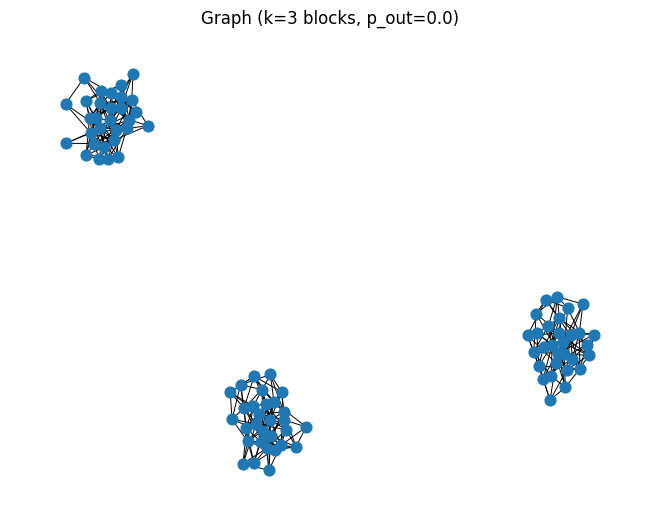

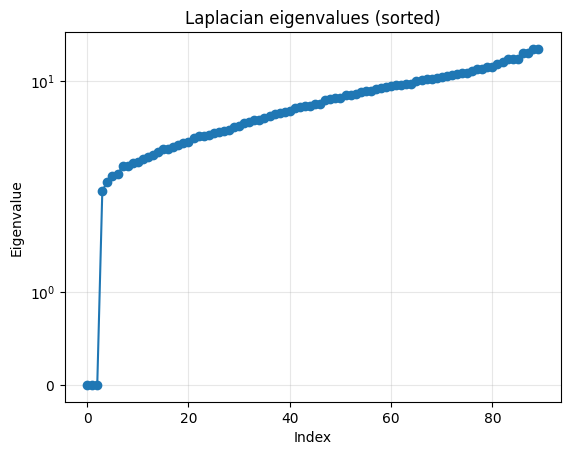

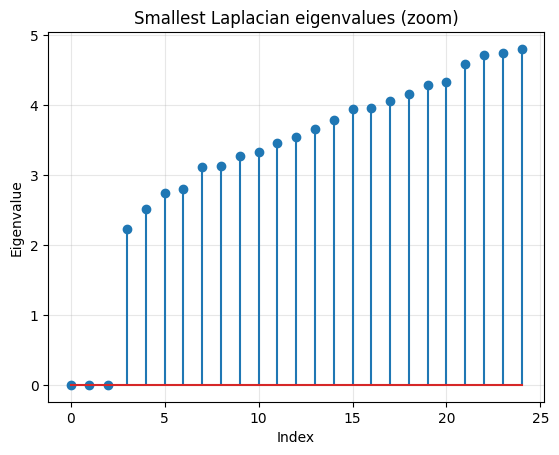

In [147]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [148]:
def update_lambda(d, beta, c1, c2):
    """
        Algorithm 1 as seen in the paper
    """

    d = np.asarray(d, dtype=float)
    q = d.size
    if q == 0:
        return d.copy()

    def g(x):
        return 0.5 * (x + np.sqrt(x*x + 4.0 / beta))

    def pav(d_seg):
        # blocks with (start,end,sum,count,lambda=g(mean))
        blocks = []
        for i, val in enumerate(d_seg):
            blocks.append([i, i, float(val), 1, g(float(val))])
            while len(blocks) >= 2 and blocks[-2][4] > blocks[-1][4]:
                b2 = blocks.pop()
                b1 = blocks.pop()
                s = b1[2] + b2[2]
                c = b1[3] + b2[3]
                blocks.append([b1[0], b2[1], s, c, g(s / c)])
        out = np.empty(len(d_seg), dtype=float)
        for a, b, s, c, lamv in blocks:
            out[a:b+1] = lamv
        return out

    left, right = 0, q
    lam = np.empty(q, dtype=float)

    while True:
        
        mid_raw = pav(d[left:right])

        # check if we need to clamp a prefix to c1
        low = np.where(mid_raw < c1)[0]
        if low.size > 0:
            left = left + low.max() + 1
            continue

        # check if we need to clamp a suffix to c2
        high = np.where(mid_raw > c2)[0]
        if high.size > 0:
            right = left + high.min()
            continue

        # feasible middle
        lam[:left] = c1
        lam[left:right] = mid_raw
        lam[right:] = c2
        return np.clip(lam, c1, c2)

Testing the correctness of the algorithm

In [149]:
def sanity_lambda():

    q = 10
    d = np.random.standard_normal(q) * 2  
    beta, c1, c2 = 400.0, 1e-3, 10.0

    lam = update_lambda(d, beta, c1, c2)

    print("min/max:", lam.min(), lam.max())
    print("monotone:", np.all(lam[:-1] <= lam[1:]))
    print("bounds ok:", lam[0] >= c1 and lam[-1] <= c2)

sanity_lambda()

min/max: 0.002170875491761315 0.0034129020774341656
monotone: True
bounds ok: True


In [150]:
Y = np.random.randn(5, 5)
evals, U = np.linalg.eigh(Y)
D = U.T @ Y @ U
d = np.diag(D)
beta = 400
lam = update_lambda(d, beta = beta, c1 = 1e-3, c2 =  1e3)

minimizsation = - np.sum(np.log(lam)) + (np.linalg.norm(lam - d) ** 2) * beta / 2
print(minimizsation)

1279.6427778160332


We do get sorted values of the eigen vals that minimize the sum.


### SGL

In [151]:
def sgl(S: np.ndarray,
        k: int,
        alpha: float = 1e-3,
        beta: float = 10.0,
        eps: float = 1e-5,
        c1: float = 1e-5,
        c2: float = 1e4,
        w0: np.ndarray | None = None,
        tol = 1e-5,
        patience = 5,
        l1 = 2.0):
    
    """
    Structured Graph Learning via Laplacian spectral constraints (SGL), Algorithm 2. :contentReference[oaicite:9]{index=9}

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """
    
    step = 0
    best = np.inf
    patience_break = 0

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)
    assert 0 <= k < p

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
        
    else:
        w = np.asarray(w0, dtype=float).copy()
        assert w.shape == (m,)
        w = np.maximum(w, 0.0)

    L1 = l1 * p

    # initialize Theta, U, lambda from current Theta
    
    Lw = L_operator(w, p, edges)
    _, evecs = np.linalg.eigh(Lw)  
    U = evecs[:, k:]

    d0 = np.diag(U.T @ Lw @ U).copy()
    lam = update_lambda(d0, beta=beta, c1=c1, c2=c2)     

    while True: 
        
        w_old = w.copy()
        
        D = np.zeros(shape=(lam.shape[0], lam.shape[0]))
        np.fill_diagonal(D, lam)
      
        c = L_adjoint((U @ D @ U.T) - (1 / beta) * S, p, edges)

        Lw = L_operator(w, p, edges) 
        grad = L_adjoint(Lw, p, edges) - c + (alpha / beta) * (1 / (eps + w))

        w = np.maximum(w - (grad / L1), 0.0)

        Lw = L_operator(w, p, edges)
        _, evecs = np.linalg.eigh(Lw)  
        U = evecs[:, k:]               

        d = np.diag(U.T @ Lw @ U).copy()
        lam = update_lambda(d, beta=beta, c1=c1, c2=c2)
        error = (np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12))

        if error < best :
            best = error
            patience_break = 0
            print(f"the best relative error is: {best}")

        elif error >= best :
            patience_break += 1

        if step % 10 == 0:
            print(f"the relative error is: {error}")

        if (np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)) < tol or patience_break == patience:
            break
        
        step += 1

    Theta = L_operator(w, p, edges)
    print(f"The best final relative error is: {best}")
    
    return Theta, w, U, lam

Application to noisy graphs

In [152]:
p = 20
k_true = 4

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [153]:
kappa=0.05
p_edge=0.1

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [154]:
Theta_noisy = Theta_true + Theta_er

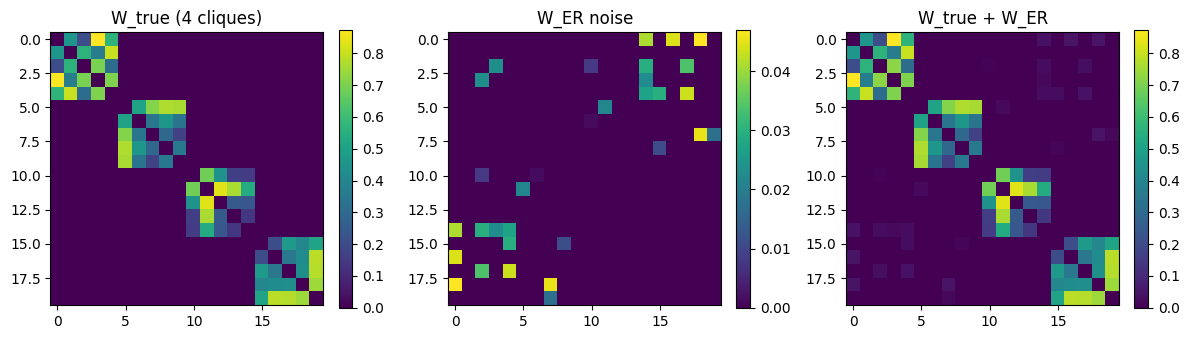

In [155]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

We wish to learn W_true from W_noise. We first calculate the covariance matrix

In [156]:
n = 200 * p
J = np.ones((p, p)) / p
Sigma = np.linalg.inv(Theta_noisy + J)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
S = np.cov(X, rowvar=False)
S_in = S + (1/3) * np.eye(p)

In [157]:
Theta_hat, w_hat, U_hat, lam_hat = sgl(
        S=S_in,
        k=k_true,
        alpha=0.01,
        beta=400.0,
        eps=1e-3,
        c1=1e-5,
        c2=1e4,
        tol=1e-5,
    )

the best relative error is: 0.23780914952352647
the relative error is: 0.23780914952352647
the best relative error is: 0.20056434273964163
the best relative error is: 0.09427834497728234
the best relative error is: 0.052374455550130136
the best relative error is: 0.03119138511734049
the best relative error is: 0.020166820190373743
the best relative error is: 0.013621834967255234
the best relative error is: 0.01029476656724012
the best relative error is: 0.008951723134957639
the best relative error is: 0.008243404013528955
the best relative error is: 0.007981621542131613
the relative error is: 0.007981621542131613
the best relative error is: 0.007511151561103231
the best relative error is: 0.007502808100843362
the best relative error is: 0.007445212886819288
the best relative error is: 0.007392287298776954
the best relative error is: 0.007365319297065013
the relative error is: 0.007525861668655201
The best final relative error is: 0.007365319297065013


In [158]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta(Theta_hat)
G_hat = nx.from_numpy_array(W_hat)

The threshold is: 0.09862021279823381


In [159]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 4
Learned components (nx): 14


In [160]:
# eigs, vecs = np.linalg.eigh(Theta_hat)
# U_k = vecs[:, :k_true]
# order = np.argsort(U_k[:, 0])  
# W_hat = W_hat[np.ix_(order, order)]

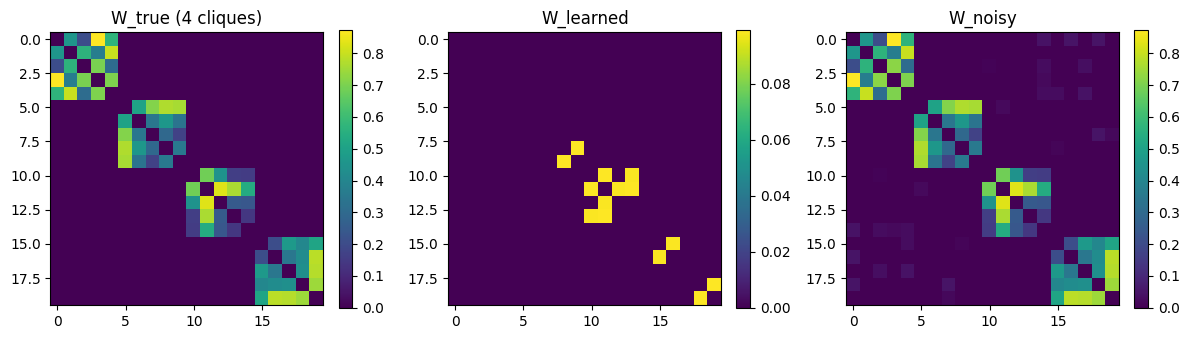

In [161]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_learned")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

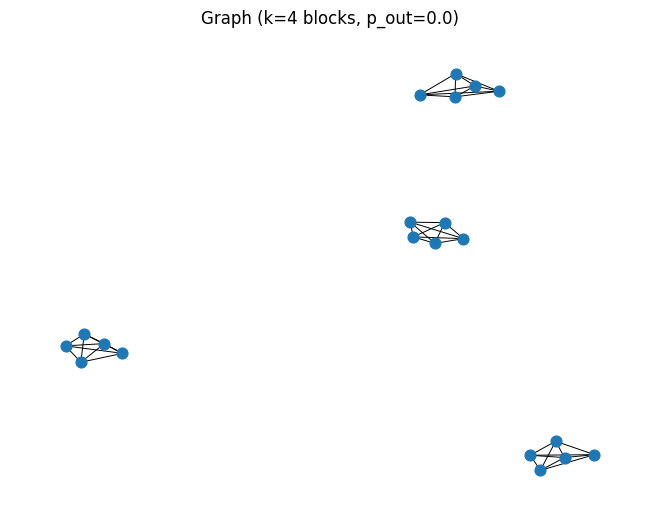

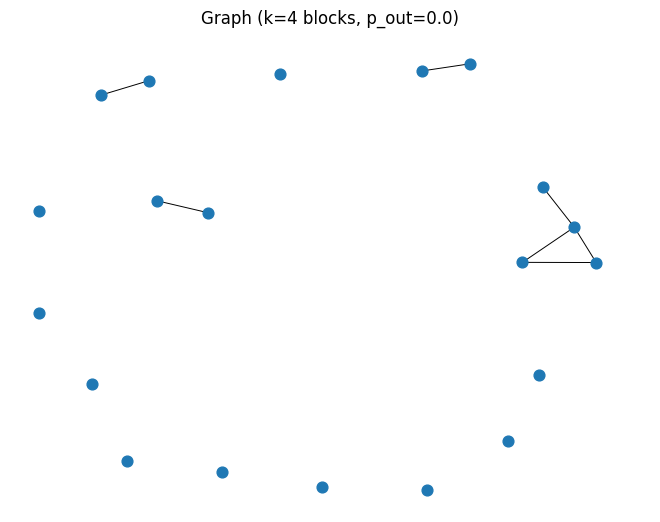

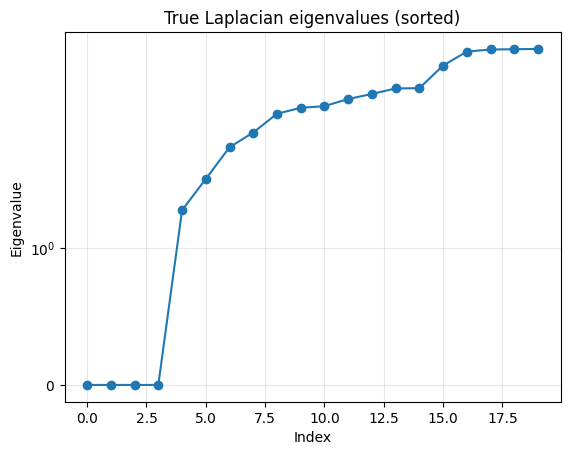

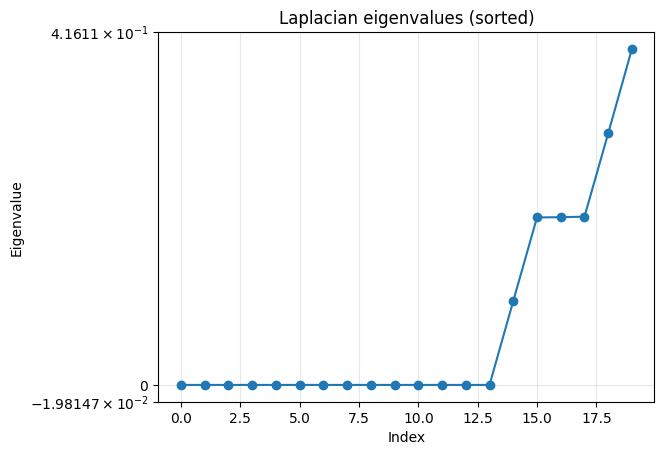

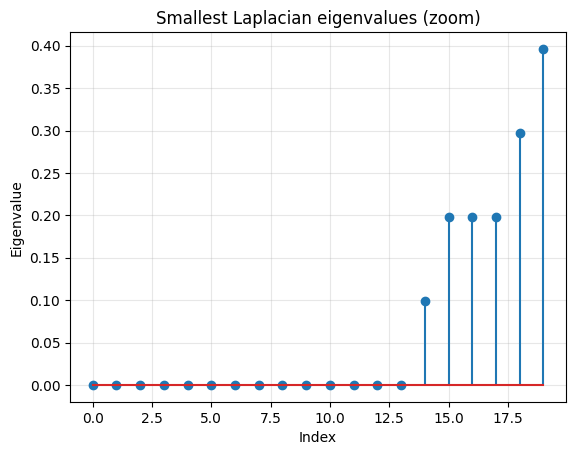

In [162]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

In [163]:
p = 49
k_true = 7

sizes = [p // k_true] * k_true  
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = np.random.uniform(0.0, 1.0, size=(sz, sz))
    W =  (W + W.T) / 2          
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

In [164]:
kappa=0.45
p_edge=1.0

M = (np.random.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = np.random.uniform(low = 0.0, high = kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

In [165]:
Theta_noisy = Theta_true + Theta_er

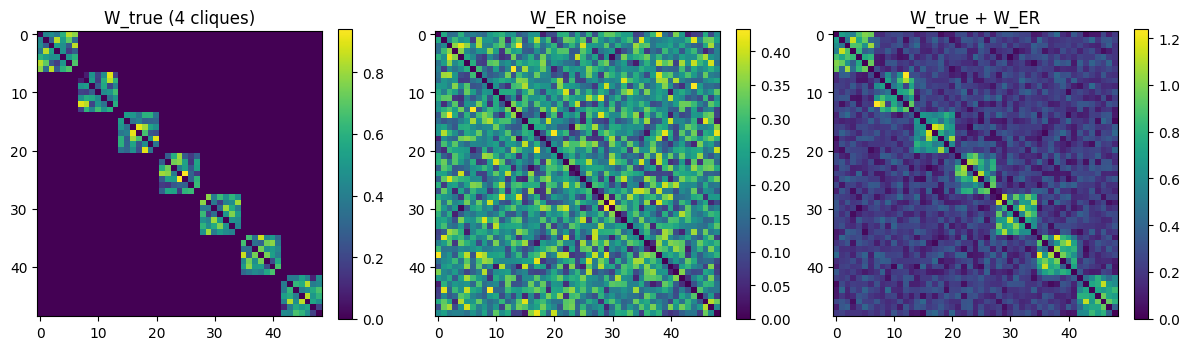

In [166]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_er)
plt.title("W_ER noise")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_true + W_ER")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [167]:
n = 30 * p
J = np.ones((p, p)) / p
Sigma = np.linalg.inv(Theta_noisy + J)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
S = np.cov(X, rowvar=False)
S_in = S + (1/3) * np.eye(p)

In [168]:
Theta_hat, w_hat, U_hat, lam_hat = sgl(
        S=S_in,
        k=2,
        alpha=0.01,
        beta=400.0,
        eps=1e-3,
        c1=1e-5,
        c2=1e4,
        tol=1e-3,
    )

the best relative error is: 0.060896425989363276
the relative error is: 0.060896425989363276
the best relative error is: 0.037642395663076166
the best relative error is: 0.018607171946216434
the best relative error is: 0.00877734569477522
the best relative error is: 0.004010657349363329
the best relative error is: 0.0025005061910416105
the best relative error is: 0.0018776961416982045
the best relative error is: 0.0014435781469015288
the best relative error is: 0.00115897889702455
the best relative error is: 0.0008604389685786019
the relative error is: 0.0008604389685786019
The best final relative error is: 0.0008604389685786019


In [169]:
G_true = nx.from_numpy_array(W_true)
W_hat = adjacency_from_theta(Theta_hat)
G_hat = nx.from_numpy_array(W_hat)

The threshold is: 0.09985866182809698


In [170]:
print("True components (nx):", nx.number_connected_components(G_true))
print("Learned components (nx):", nx.number_connected_components(G_hat))

True components (nx): 7
Learned components (nx): 17


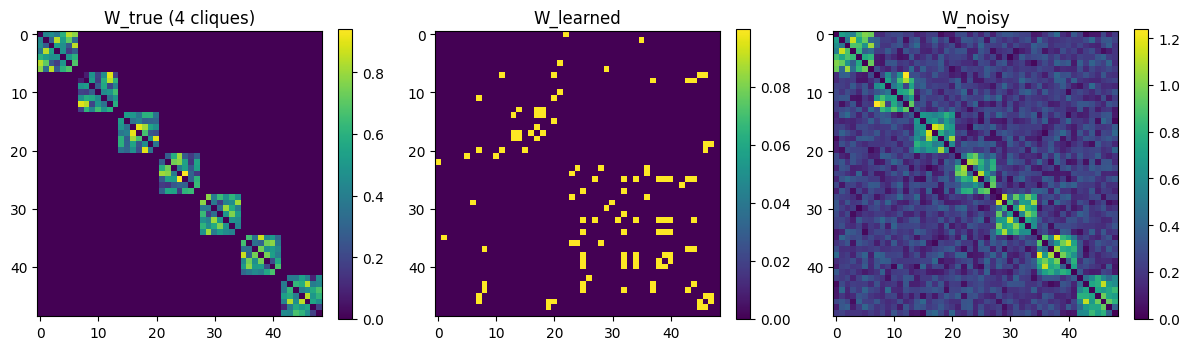

In [171]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(W_true)
plt.title("W_true (4 cliques)")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,2)
plt.imshow(W_hat)
plt.title("W_learned")
plt.colorbar(fraction=0.046)

plt.subplot(1,3,3)
plt.imshow(W_true + W_er)
plt.title("W_noisy")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

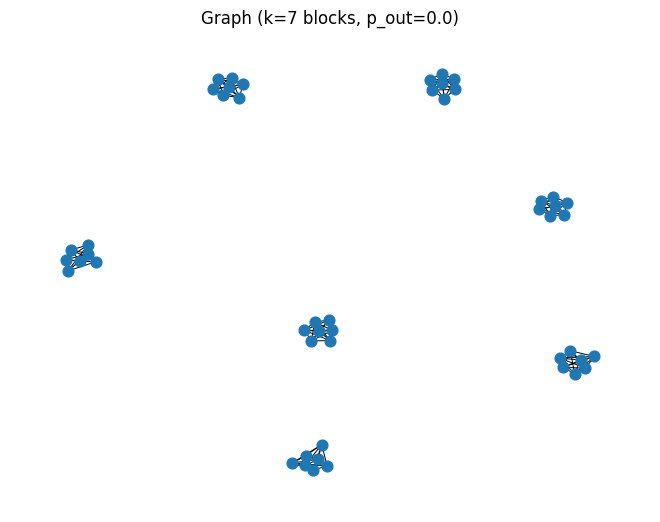

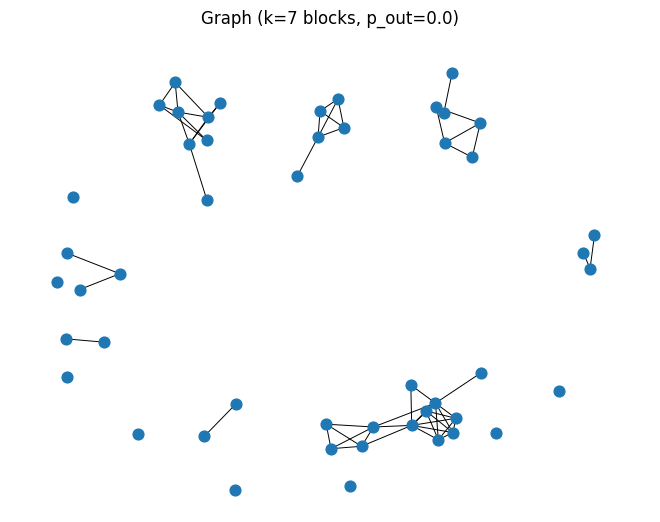

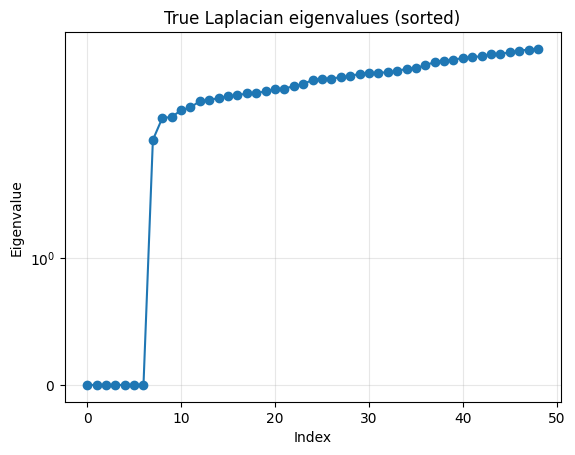

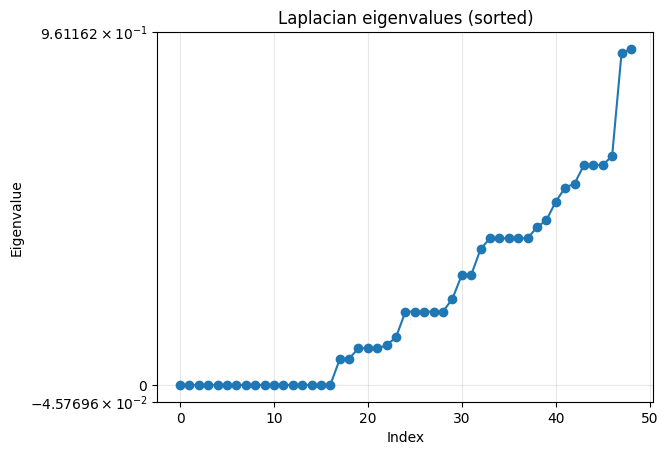

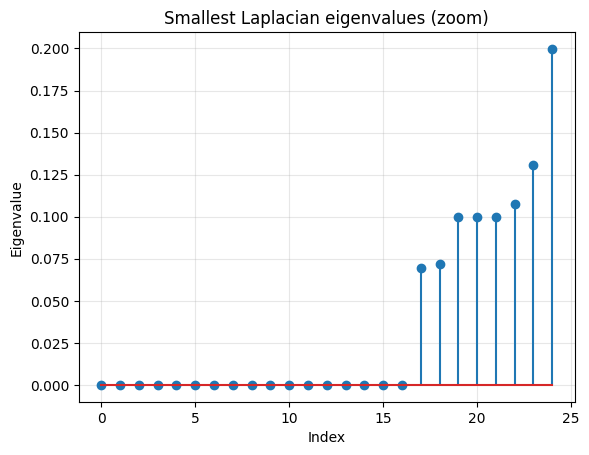

In [172]:
L_hat = laplacian_from_W(W_hat)
L_true = laplacian_from_W(W_true)
eigs_hat = np.linalg.eigvalsh(L_hat)
eigs_true = np.linalg.eigvalsh(L_true)

plt.figure()
pos = nx.spring_layout(G_true)
nx.draw(G_true, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
pos = nx.spring_layout(G_hat)
nx.draw(G_hat, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs_true, marker="o")
plt.yscale("symlog")  
plt.title("True Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(eigs_hat, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs_hat))
plt.stem(range(m), eigs_hat[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

### Animal Dataset

In [173]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [174]:
A_animals = np.asarray(A_animals) 
print(f"The shape of the dataset is: {A_animals.shape}")

X_animals = A_animals.T
std = X_animals.std(axis=0, keepdims=True)
Xc = X_animals - X_animals.mean(axis=0, keepdims=True)

Xz = Xc / std

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
S_in_animals = S_animals + (1/3) * np.eye(p)

Theta_hat_animals, w_hat, U_hat, lam_hat = sgl(
    S=S_in_animals,
    k=5,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    tol=1e-5
)

The shape of the dataset is: (50, 85)
the best relative error is: 0.4683045503407231
the relative error is: 0.4683045503407231
the best relative error is: 0.3708285022978032
the best relative error is: 0.24536157437277434
the best relative error is: 0.17211633560160805
the best relative error is: 0.12526773677641784
the best relative error is: 0.09975941383027613
the best relative error is: 0.08763100444365379
the best relative error is: 0.0749797136062992
the best relative error is: 0.0671643748447028
the relative error is: 0.0671643748447028
the best relative error is: 0.058248629100262836
the best relative error is: 0.05264535641153816
the best relative error is: 0.0460720036022552
the best relative error is: 0.042035412779278226
the best relative error is: 0.0388300556790259
the best relative error is: 0.035850654196563025
the best relative error is: 0.03420087368929725
the best relative error is: 0.03291281596117112
the best relative error is: 0.03123283852354626
the best relative

In [175]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

The threshold is: 0.37709519509173944


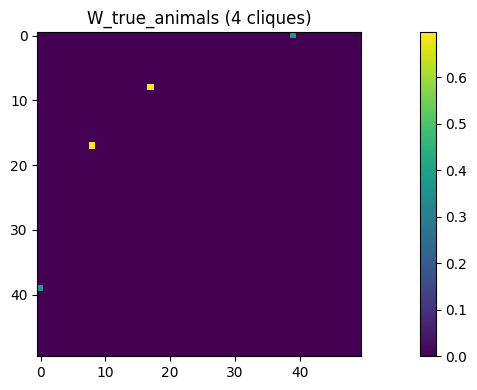

In [176]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [177]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))  

Learned components (nx): 48


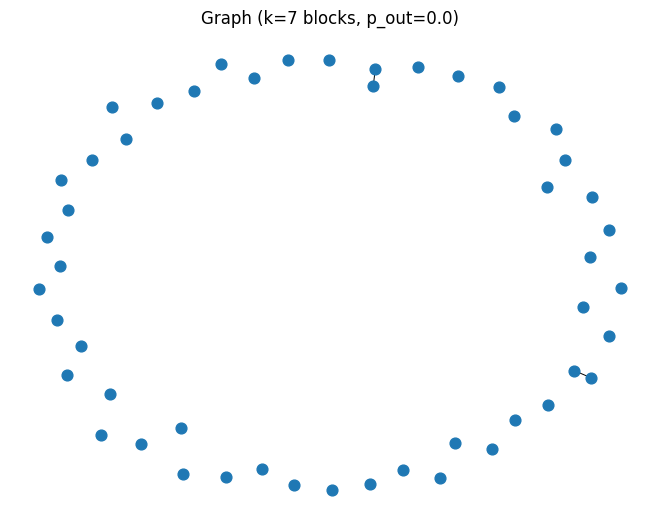

In [178]:
plt.figure()
pos = nx.spring_layout(G_hat_animals)
nx.draw(G_hat_animals, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

### Moons, circles and clusters

In [179]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [180]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.3

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

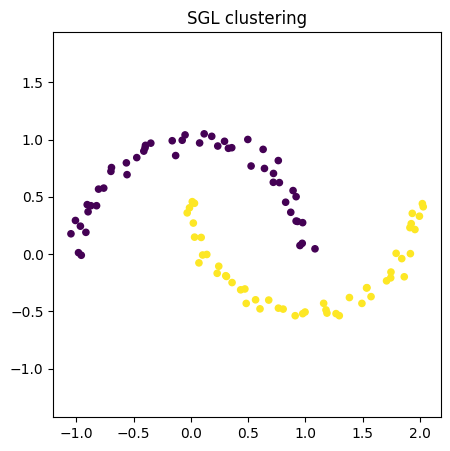

In [181]:
plt.figure(figsize=(5,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

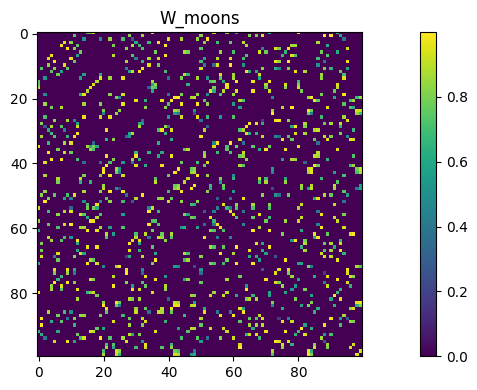

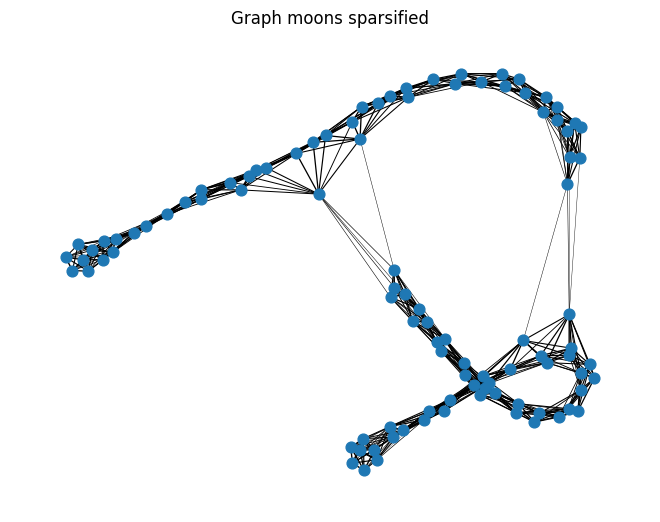

In [182]:
W_moons = gaussian_similarity(X_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

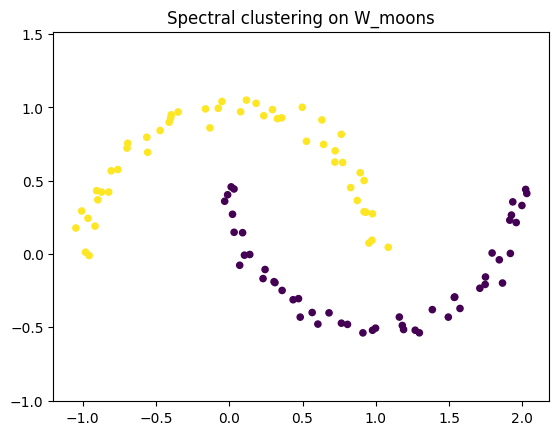

In [183]:
from sklearn.cluster import SpectralClustering

labels_sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

In [184]:
p = W_moons.shape[0]
S_moons = W_moons + (1/3) * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons = sgl(
    S=S_moons,
    k=2,
    alpha=0.0,     
    beta=100.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    tol=1e-5,
    patience=50,
    l1 = 50.0,
)

the best relative error is: 0.001471980984239668
the relative error is: 0.001471980984239668
the relative error is: 0.0023641253612787915
the relative error is: 0.0019322479191845857
the relative error is: 0.001578061944599255
the best relative error is: 0.0014550637140607245
the best relative error is: 0.0014258265446284778
the best relative error is: 0.0013971711612900865
the best relative error is: 0.001369086329652338
the best relative error is: 0.001341561012050885
the best relative error is: 0.0013145843653336428
the best relative error is: 0.0012881457385879147
the relative error is: 0.0012881457385879147
the best relative error is: 0.0012622346708181234
the best relative error is: 0.00123684088858055
the best relative error is: 0.0012119543035810627
the best relative error is: 0.0011875650102413902
the best relative error is: 0.0011636632832391146
the best relative error is: 0.0011402395750262316
the best relative error is: 0.0011172845133307335
the best relative error is: 0.00

In [185]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons)
thr_hat = np.quantile(W_hat_moons[W_hat_moons > 0], 0.9) 
print(f"The threshold is: {thr_hat}")
W_hat_moons[W_hat_moons < thr_hat] = 0.0
G_hat_moons = nx.from_numpy_array(W_hat_moons)

The threshold is: 0.10114711354679297
The threshold is: 0.10146025165721886


/home/iliass/.local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


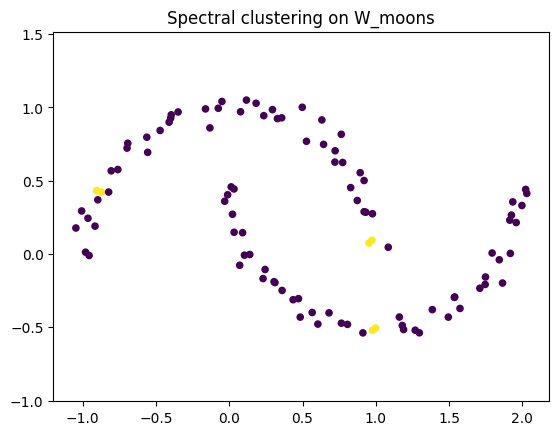

In [186]:
labels_sc_hat_moons = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_hat_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc_hat_moons, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

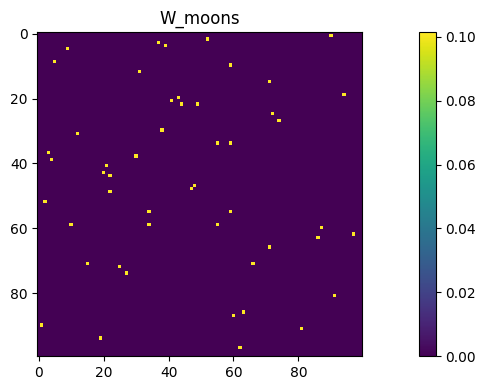

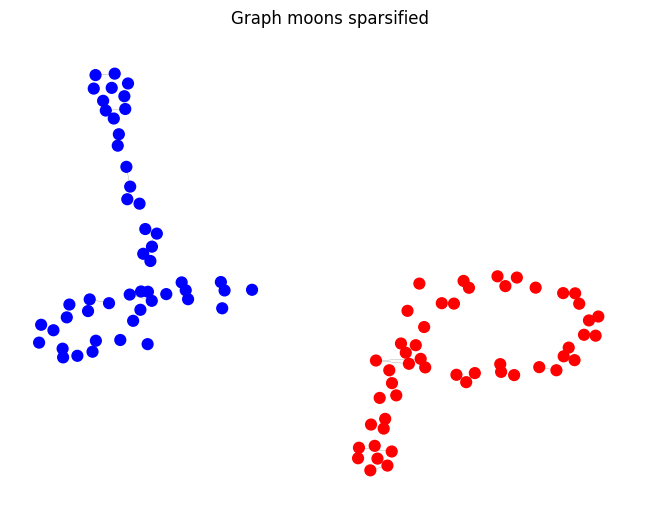

In [187]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

### SGA Algorithm

In [188]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def count_components_from_eigs(eigs, tol=1e-8):
    return int(np.sum(eigs < tol))

Adjacency algorithm

In [189]:
def A_operator(w: np.ndarray, p: int, edges=None):
    """
    Adjacency operator A : w -> W = Aw
    Off-diagonal: W_ij = w_k, diag = 0 (See page 19)
    """

    if edges is None:
        edges = edge_list(p)
        
    W = np.zeros((p, p), dtype=float)
    
    for wk, (i, j) in zip(w, edges):

        W[i, j] = wk
        W[j, i] = wk
    
    np.fill_diagonal(W, 0.0)

    return W

def A_adjoint(Y: np.ndarray, p: int, edges=None):
    """
    Adjoint A* : Y -> vector where each entry is Y_ij + Y_ji (See paper page 19)
    """

    if edges is None:
        edges = edge_list(p)

    out = np.zeros(len(edges), dtype=float)
    
    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, j] + Y[j, i]
    
    return out

Testing the correctness of the adjacency operator.

In [190]:
p = 4
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
A = A_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(A * Y)  
right = np.dot(w, A_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 3.552713678800501e-15


In [191]:
def V_from_Aw(Aw: np.ndarray, z: int):
        
        _, evecs = np.linalg.eigh(Aw)  
        a = (p - z) // 2
        b = (p + z) // 2
        
        V = np.concatenate([evecs[:, :a], evecs[:, b:]], axis=1)
        return V

In [192]:
def update_psi_with_update_lambda(e, c1, c2, beta_lam):

        """
        Adaptation of the lambda Algo
        """

        e = np.asarray(e, float)
        b = e.size
        assert b % 2 == 0
        half = b // 2

        
        t = (e[:half] - e[::-1][:half]) / 2
        
        t_proj_inc = update_lambda(-t, beta=beta_lam, c1=-c1, c2=-c2)
        t_proj = -t_proj_inc

        psi = np.concatenate([t_proj, -t_proj[::-1]])
        return psi

In [193]:
def sga(S: np.ndarray,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2.0 * p
   
    Aw = A_operator(w, p, edges)
    

    V = V_from_Aw(Aw, z=z)
    
    e = np.diag(V.T @ Aw @ V).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

    while True:

        w_old = w.copy()

        Lmat = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        M = Lmat + J
        Minv = np.linalg.inv(M)
        grad_f1 = - (1.0 / gamma) * L_adjoint(Minv, p, edges)

        
        c_tilde = A_adjoint((V * psi) @ V.T, p, edges) - (1.0 / gamma) * L_adjoint(S, p, edges)
        grad_f2 = A_adjoint(Aw, p, edges) - c_tilde

        
        grad_f3 = (alpha / gamma) * (1.0 / (eps + w))

        grad = grad_f1 + grad_f2 + grad_f3
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
 
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break


    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

### SGLA Algorithm

In [194]:
def sgla(S: np.ndarray,
        k : int,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2 * (p * beta + gamma)

    Aw = A_operator(w, p, edges)
    Lw = L_operator(w, p, edges)

    V = V_from_Aw(Aw, z=z)
    _, U = np.linalg.eigh(Lw)
    U = U[:, k :]
    
    e = np.diag(V.T @ Aw @ V).copy()
    d = np.diag(U.T @ Lw @ U).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
    lam = update_lambda(d, c1 = c1, c2 = c2, beta=beta)

    while True:

        w_old = w.copy()

        Lw = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        c_1 = beta * L_adjoint((U * lam) @ U.T - S / beta, p = p, edges=edges)
        c_2 = gamma * A_adjoint((V * psi) @ V.T, p = p, edges = edges)
        b_1 = alpha / (eps + w)

        grad_f1 = beta * L_adjoint(Lw, p = p, edges=edges) - c_1 + b_1
        grad_f2 = gamma * A_adjoint(Aw, p = p, edges = edges) - c_2

        grad = grad_f1 + grad_f2 
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
        _, U = np.linalg.eigh(Lw)
        U = U[:, k :]

        d = np.diag(U.T @ Lw @ U).copy()
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
        lam = update_lambda(d, c1 = c1, c2 = c2, beta = beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break

    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

Implémentation

Lancement de SGL sur la matrice de covariance...
the best relative error is: 0.5996109408548469
the relative error is: 0.5996109408548469
the best relative error is: 0.024682700323365937
The best final relative error is: 0.024682700323365937
The threshold is: 0.1083951298581458

Matrice d'adjacence apprise :
[[0.    0.108 0.   ]
 [0.108 0.    0.   ]
 [0.    0.    0.   ]]


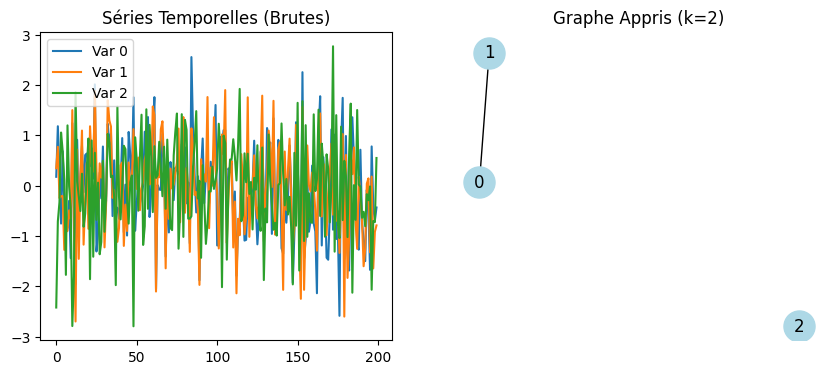

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Supposons que les fonctions sgl, adjacency_from_theta, etc. sont déjà définies

def learn_graph_from_time_series(X, k_components=1):
    """
    Apprend un graphe à partir de séries temporelles multivariées.
    
    Args:
        X: np.ndarray de forme (T, p) où T est le temps et p le nombre de variables.
        k_components: int, nombre de composantes connexes souhaitées.
        
    Returns:
        W_hat: Matrice d'adjacence apprise.
    """
    # 1. Prétraitement : Centrer et Réduire les données (Z-score normalization)
    # C'est important pour que la covariance soit comparable à une corrélation
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    # Éviter la division par zéro
    X_std[X_std == 0] = 1.0 
    X_normalized = (X - X_mean) / X_std
    
    # 2. Calcul de la matrice de covariance empirique S
    # rowvar=False car les variables sont les colonnes
    S = np.cov(X_normalized, rowvar=False)
    
    # Optionnel : Ajouter une petite régularisation à la diagonale si S est mal conditionnée
    # S = S + 1e-6 * np.eye(S.shape[0])
    
    # 3. Appliquer SGL
    # Les hyperparamètres (alpha, beta) peuvent nécessiter un ajustement selon les données
    print("Lancement de SGL sur la matrice de covariance...")
    Theta, w, U, lam = sgl(
        S=S,
        k=k_components,
        alpha=0.01, # Paramètre de sparsité (L1)
        beta=100.0, # Paramètre de pénalité spectrale
        tol=1e-4
    )
    
    # 4. Convertir le Laplacien appris en matrice d'adjacence
    W_hat = adjacency_from_theta(Theta)
    
    return W_hat

# --- Exemple d'utilisation avec des données synthétiques ---

# Générons 3 séries temporelles où 0 et 1 sont corrélés, et 2 est indépendant
T = 200
p = 3
# Vérité terrain (covariance)
true_cov = np.array([
    [1.0, 0.8, 0.0],
    [0.8, 1.0, 0.0],
    [0.0, 0.0, 1.0]
])
# Génération des séries
X_synth = np.random.multivariate_normal(mean=np.zeros(p), cov=true_cov, size=T)

# Apprentissage
W_learned = learn_graph_from_time_series(X_synth, k_components=2)

# Visualisation
print("\nMatrice d'adjacence apprise :")
print(np.round(W_learned, 3))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(X_synth)
plt.title("Séries Temporelles (Brutes)")
plt.legend(["Var 0", "Var 1", "Var 2"])

plt.subplot(1, 2, 2)
G_learned = nx.from_numpy_array(W_learned)
pos = nx.spring_layout(G_learned)
nx.draw(G_learned, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Graphe Appris (k=2)")
plt.show()


In [196]:
!pip install statsmodels tqdm

Defaulting to user installation because normal site-packages is not writeable


Dataset chargé : 203 trimestres x 11 variables
Variables : ['realgdp', 'realcons', 'realinv', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']


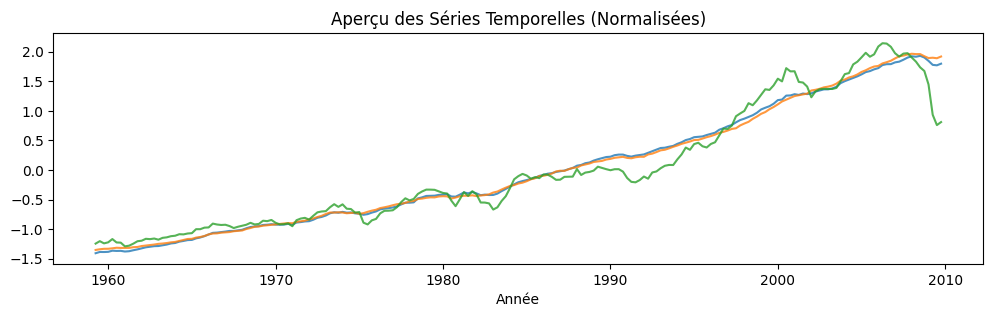

In [197]:
# --- CELLULE A : Chargement de Données Réelles (US Macroeconomy) ---
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Chargement du dataset (Déjà intégré dans statsmodels)
# NOTE : Pour vos propres données, remplacez simplement par : df = pd.read_csv("votre_fichier.csv")
dataset = sm.datasets.macrodata.load_pandas()
df = dataset.data

# 2. Sélection des variables intéressantes (Multivariate Time Series)
# On garde : PIB, Conso, Investissement, Revenu, Inflation, Chômage, Taux d'intérêt, etc.
cols_to_keep = ['realgdp', 'realcons', 'realinv', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']
X_raw = df[cols_to_keep].values
timestamps = df['year'] + df['quarter']/4  # Pour l'axe temporel

# 3. Prétraitement (Standardisation)
# SGL travaille sur la covariance, il est vital que les variables soient à la même échelle
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_raw)

print(f"Dataset chargé : {X_normalized.shape[0]} trimestres x {X_normalized.shape[1]} variables")
print("Variables :", cols_to_keep)

# Visualisation rapide
plt.figure(figsize=(12, 3))
plt.plot(timestamps, X_normalized[:, :3], alpha=0.8)
plt.title("Aperçu des Séries Temporelles (Normalisées)")
plt.xlabel("Année")
plt.show()

In [198]:
# --- CELLULE B : Analyse Dynamique (Rolling Window) ---
from tqdm import tqdm

def run_dynamic_sgl(X, dates, window_size=40, step=2, k_clusters=3):
    """
    Applique SGL sur une fenêtre glissante pour voir l'évolution du graphe.
    """
    n_samples, p = X.shape
    num_windows = (n_samples - window_size) // step
    
    history_graphs = []
    history_dates = []
    w_prev = None  # Pour le Warm Start
    
    print(f"Analyse en cours sur {num_windows} fenêtres...")
    
    for i in tqdm(range(num_windows)):
        # 1. Découpage de la fenêtre
        start = i * step
        end = start + window_size
        X_window = X[start:end]
        current_date = dates[end-1]
        
        # 2. Calcul de la Covariance Locale
        # On ajoute un petit terme de régularisation pour la stabilité numérique
        S_sample = np.cov(X_window, rowvar=False)
        S_reg = S_sample + (0.1 * np.eye(p)) 
        
        # 3. Exécution de SGL
        try:
            # On utilise w_prev pour initialiser (accélère la convergence)
            Theta_t, w_t, _, _ = sgl(
                S=S_reg,
                k=k_clusters,
                alpha=0.05,    # Sparsité (à ajuster selon le dataset)
                beta=50.0,     # Force de la contrainte spectrale
                tol=1e-4,
                w0=w_prev,     # WARM START
                patience=10
            )
            
            # Conversion en matrice d'adjacence binaire pour l'analyse
            W_t = adjacency_from_theta(Theta_t)
            
            history_graphs.append(W_t)
            history_dates.append(current_date)
            w_prev = w_t
            
        except Exception as e:
            print(f"Erreur fenêtre {i}: {e}")
            history_graphs.append(np.zeros((p, p)))

    return history_graphs, history_dates

# Paramètres : Fenêtre de 40 trimestres (10 ans), on avance de 6 mois (step=2)
# On cherche k=3 clusters majeurs (ex: Production, Monétaire, Emploi)
graphs, dates = run_dynamic_sgl(X_normalized, timestamps.values, window_size=40, step=2, k_clusters=3)

Analyse en cours sur 81 fenêtres...


  0%|          | 0/81 [00:00<?, ?it/s]

the best relative error is: 0.23872760838596369
the relative error is: 0.23872760838596369
the best relative error is: 0.22431849946004206
the best relative error is: 0.1693599661403349
the best relative error is: 0.10863754443475725
the best relative error is: 0.06882962702323984
the best relative error is: 0.034659044237158466
the best relative error is: 0.0233862048340352
the best relative error is: 0.02276218075309254
the best relative error is: 0.022357396034586332
the best relative error is: 0.02195311787528458
the best relative error is: 0.021591473862859756
the relative error is: 0.021591473862859756
the best relative error is: 0.021342187268947276
the best relative error is: 0.017842673942761345
the best relative error is: 0.014327386458154814
the best relative error is: 0.014010784893401922
the best relative error is: 0.01371089646884273
the best relative error is: 0.013427437979654478
the best relative error is: 0.013160588024281494
the relative error is: 0.01316058802428149

  2%|▏         | 2/81 [00:00<00:06, 11.43it/s]

the best relative error is: 0.0008907283221600006
the best relative error is: 0.0008888906826007055
the best relative error is: 0.0008870622851243732
the relative error is: 0.0008870622851243732
the best relative error is: 0.0008852430891769962
the best relative error is: 0.0008834330549340876
the best relative error is: 0.0008816321432999363
the best relative error is: 0.0008798403159100823
the best relative error is: 0.0008780575351332985
the best relative error is: 0.0008762837640809395
the best relative error is: 0.0008745189666026493
the best relative error is: 0.0008727631072927956
the best relative error is: 0.000871016151495723
the best relative error is: 0.0008692780653057245
the relative error is: 0.0008692780653057245
the best relative error is: 0.00086754881558076
the best relative error is: 0.000865828369934834
the best relative error is: 0.0008641166967565314
the best relative error is: 0.0008624137652009825
the best relative error is: 0.0008607195452105388
the best relat

  9%|▊         | 7/81 [00:00<00:03, 19.19it/s]

the best relative error is: 0.0003290078006542414
the best relative error is: 0.00032871441204268976
the best relative error is: 0.000328422034694167
the best relative error is: 0.00032813066890384615
the best relative error is: 0.0003278403150091011
the best relative error is: 0.00032755097339848656
the best relative error is: 0.0003272626445041418
the relative error is: 0.0003272626445041418
the best relative error is: 0.00032697532880657996
the best relative error is: 0.0003266890268370699
the best relative error is: 0.00032640373917016313
the best relative error is: 0.0003261194664377409
the best relative error is: 0.00032583620931647466
the best relative error is: 0.00032555396853330685
the best relative error is: 0.00032527274487111584
the best relative error is: 0.00032499253916040254
the best relative error is: 0.00032471335228953556
the best relative error is: 0.0003244351851954088
the relative error is: 0.0003244351851954088
the best relative error is: 0.0003241580388720323
t

 32%|███▏      | 26/81 [00:00<00:01, 54.99it/s]

the best relative error is: 0.000592530466022633
the best relative error is: 0.0005919841520701397
the best relative error is: 0.0005914377829342359
the best relative error is: 0.0005908913682069613
the relative error is: 0.0005908913682069613
the best relative error is: 0.0005903449176397093
the best relative error is: 0.0005897984411452788
the best relative error is: 0.0005892519488021016
the best relative error is: 0.0005887054508571927
the best relative error is: 0.0005881589577309387
the best relative error is: 0.0005876124800185187
the best relative error is: 0.00058706602849673
the best relative error is: 0.0005865196141260462
the best relative error is: 0.0005859732480543415
the best relative error is: 0.0005854269416236794
the relative error is: 0.0005854269416236794
the best relative error is: 0.0005848807063719505
the best relative error is: 0.0005843345540378689
the best relative error is: 0.0005837884965671755
the best relative error is: 0.0005832425461164999
the best rela

 48%|████▊     | 39/81 [00:00<00:00, 68.83it/s]

the relative error is: 0.0007394427648177442
The best final relative error is: 0.000694144328523562
The threshold is: 0.7103918885300917
the best relative error is: 0.0007438692494190629
the relative error is: 0.0007438692494190629
the relative error is: 0.0010713921441118828
The best final relative error is: 0.0007438692494190629
The threshold is: 0.7121970796631133
the best relative error is: 0.001199390772999393
the relative error is: 0.001199390772999393
the best relative error is: 0.0004946587239930038
the best relative error is: 0.0004939880373078389
the best relative error is: 0.0004933197665986865
the best relative error is: 0.0004926539590274212
the best relative error is: 0.0004919906633217937
the best relative error is: 0.0004913299298308821
the best relative error is: 0.0004906718105855078
the relative error is: 0.0004906718105855078
the best relative error is: 0.0004900163593623161
the best relative error is: 0.00048936363174712
the best relative error is: 0.00048871368520

 58%|█████▊    | 47/81 [00:00<00:00, 66.30it/s]

the best relative error is: 0.00029924860107824464
the best relative error is: 0.0002989572299652702
the best relative error is: 0.0002986702572527397
the best relative error is: 0.0002983877489183647
the best relative error is: 0.00029810977276017797
the best relative error is: 0.00029783639845789255
the best relative error is: 0.00029756769764248457
the best relative error is: 0.0002973037439651498
the best relative error is: 0.0002970446131732893
the best relative error is: 0.00029679038318575766
the relative error is: 0.00029679038318575766
the best relative error is: 0.0002965411341729125
the best relative error is: 0.00029629694864313864
the best relative error is: 0.00029605791152874004
the best relative error is: 0.00029582411027830903
the best relative error is: 0.00029559563495225213
the best relative error is: 0.0002953725783263788
the best relative error is: 0.00029515503599394986
the best relative error is: 0.00029494310647723576
the best relative error is: 0.0002947368913

 67%|██████▋   | 54/81 [00:01<00:00, 47.80it/s]

the best relative error is: 0.00017611890682845741
the best relative error is: 0.00017597360364579403
the relative error is: 0.00017597360364579403
the best relative error is: 0.0001758287542195372
the best relative error is: 0.00017568435725528236
the best relative error is: 0.00017554041146798402
the best relative error is: 0.00017539691558252692
the best relative error is: 0.00017525386833439568
the best relative error is: 0.00017511126847032695
the best relative error is: 0.000174969114746389
the best relative error is: 0.00017482740592966516
the best relative error is: 0.00017468614079603123
the best relative error is: 0.0001745453181328022
the relative error is: 0.0001745453181328022
the best relative error is: 0.00017440493673839903
the best relative error is: 0.0001742649954189322
the best relative error is: 0.0001741254929936949
the best relative error is: 0.00017398642828892253
the best relative error is: 0.00017384780014408503
the best relative error is: 0.000173709607406468

 85%|████████▌ | 69/81 [00:01<00:00, 57.62it/s]

the best relative error is: 0.00012204654525958644
the best relative error is: 0.00012194894672931977
the best relative error is: 0.00012185155947121199
the best relative error is: 0.00012175438283804862
the relative error is: 0.00012175438283804862
the best relative error is: 0.00012165741618674473
the best relative error is: 0.00012156065887565902
the best relative error is: 0.00012146411026675653
the best relative error is: 0.00012136776972222852
the best relative error is: 0.00012127163661008236
the best relative error is: 0.00012117571029804323
the best relative error is: 0.00012107999015751224
the best relative error is: 0.00012098447556254645
the best relative error is: 0.0001208891658897129
the best relative error is: 0.00012079406051707206
the relative error is: 0.00012079406051707206
the best relative error is: 0.00012069915882608185
the best relative error is: 0.00012060446020052259
the best relative error is: 0.00012050996402644771
the best relative error is: 0.000120415669

 94%|█████████▍| 76/81 [00:01<00:00, 33.34it/s]

the best relative error is: 0.00010806486049756344
the best relative error is: 0.00010796636222276787
the relative error is: 0.00010796636222276787
the best relative error is: 0.00010786827044649031
the best relative error is: 0.00010777058418938597
the best relative error is: 0.00010767330246678356
the best relative error is: 0.00010757642429287305
the best relative error is: 0.00010747994867733139
the best relative error is: 0.00010738387462594187
the best relative error is: 0.00010728820114236988
the best relative error is: 0.00010719292722639736
the best relative error is: 0.00010709805187531205
the best relative error is: 0.00010700357408164276
the relative error is: 0.00010700357408164276
the best relative error is: 0.0001069094928373661
the best relative error is: 0.00010681580712931742
the best relative error is: 0.0001067225159422454
the best relative error is: 0.0001066296182584729
the best relative error is: 0.00010653711305650487
the best relative error is: 0.00010644499931

100%|██████████| 81/81 [00:02<00:00, 40.35it/s]

the best relative error is: 0.00010144236306442348
the best relative error is: 0.0001014310075196747
the best relative error is: 0.00010141998743072861
the best relative error is: 0.00010140930438252718
the best relative error is: 0.00010139895998965973
the relative error is: 0.00010139895998965973
the best relative error is: 0.00010138895589355342
the best relative error is: 0.0001013792937621394
the best relative error is: 0.00010136997529024528
the best relative error is: 0.00010136100220263077
the best relative error is: 0.00010135237625379638
the best relative error is: 0.00010134409922501332
the best relative error is: 0.00010133617292710538
the best relative error is: 0.00010132859920227474
the best relative error is: 0.00010132137992174478
the best relative error is: 0.00010131451699031416
the relative error is: 0.00010131451699031416
the best relative error is: 0.0001013080123398307
the best relative error is: 0.00010130186793580549
the best relative error is: 0.00010129608577

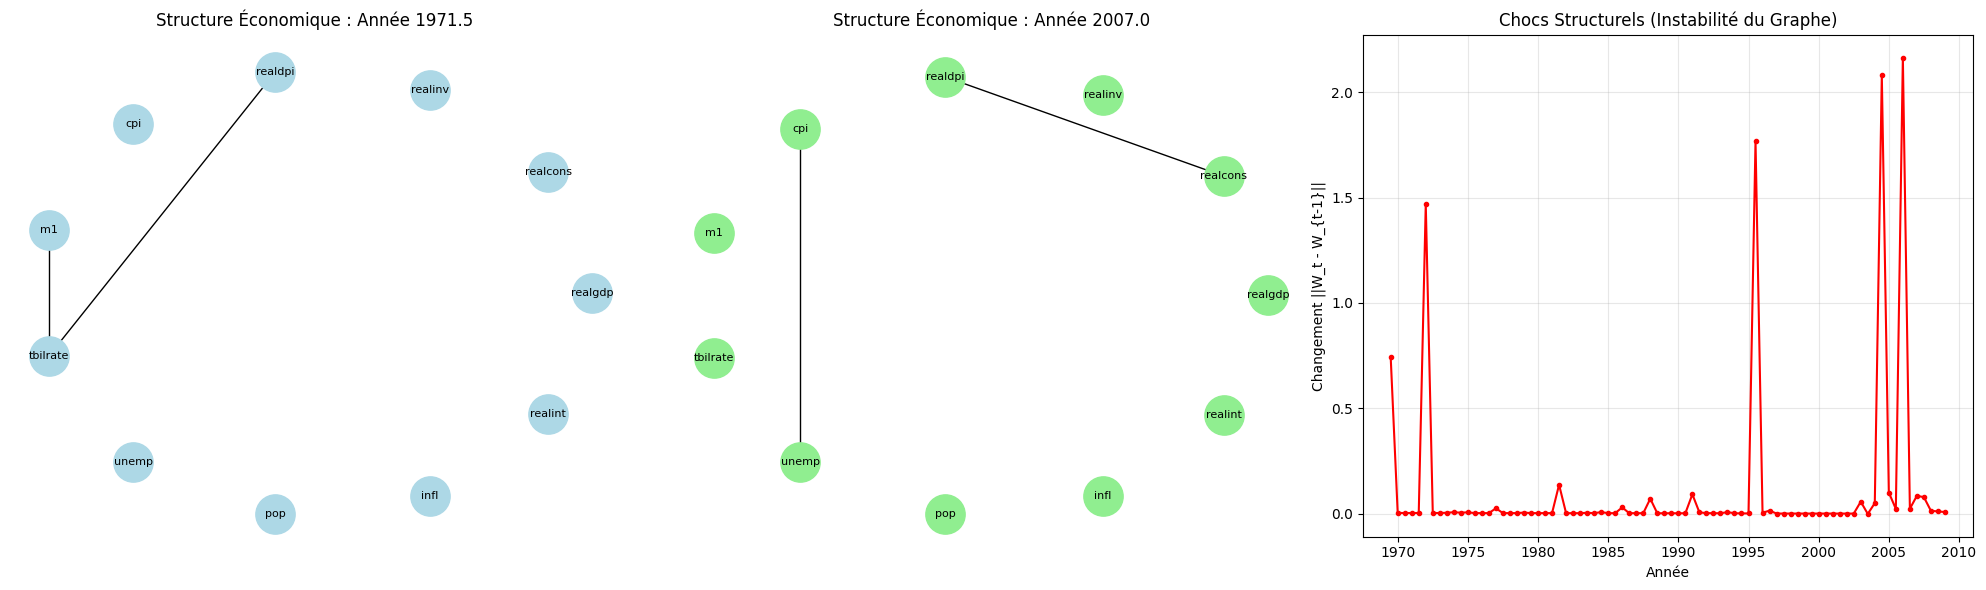

In [199]:
# --- CELLULE C : Tableau de Bord des Résultats ---

# Comparaison entre deux époques (ex: Années 60 vs Années 2000)
idx_A = 5                   # Début de l'historique
idx_B = len(graphs) - 5     # Fin de l'historique

W_A = graphs[idx_A]
W_B = graphs[idx_B]
date_A = dates[idx_A]
date_B = dates[idx_B]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Graphe A
G_A = nx.from_numpy_array(W_A)
pos = nx.circular_layout(G_A) # Layout circulaire pour bien voir les liens
nx.draw(G_A, pos, ax=axes[0], with_labels=True, labels={i:cols_to_keep[i] for i in range(len(cols_to_keep))}, 
        node_color='lightblue', node_size=800, font_size=8)
axes[0].set_title(f"Structure Économique : Année {date_A:.1f}")

# Graphe B
G_B = nx.from_numpy_array(W_B)
nx.draw(G_B, pos, ax=axes[1], with_labels=True, labels={i:cols_to_keep[i] for i in range(len(cols_to_keep))}, 
        node_color='lightgreen', node_size=800, font_size=8)
axes[1].set_title(f"Structure Économique : Année {date_B:.1f}")

# Stabilité Temporelle
# On calcule la différence (Norme de Frobenius) entre t et t-1
changes = [np.linalg.norm(graphs[i] - graphs[i-1]) for i in range(1, len(graphs))]
axes[2].plot(dates[1:], changes, color='r', marker='o', markersize=3)
axes[2].set_title("Chocs Structurels (Instabilité du Graphe)")
axes[2].set_ylabel("Changement ||W_t - W_{t-1}||")
axes[2].set_xlabel("Année")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [200]:
# --- CELLULE E (CORRIGÉE) : Application Neurosciences ---

def get_brain_data():
    """
    Tente de récupérer de vraies données fMRI (Haxby/ADHD).
    Sinon, génère un cerveau synthétique avec 4 réseaux fonctionnels.
    """
    try:
        # Essai avec Nilearn (Standard en Neurosciences)
        # Si vous n'avez pas nilearn, cela sautera directement au bloc 'except'
        from nilearn import datasets
        from nilearn.input_data import NiftiLabelsMasker
        
        print("Téléchargement des données fMRI (ADHD200)...")
        dataset = datasets.fetch_adhd(n_subjects=1)
        atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
        
        masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
        time_series = masker.fit_transform(dataset.func[0])
        
        valid_rois = np.std(time_series, axis=0) > 0
        X = time_series[:, valid_rois]
        labels = [l for i, l in enumerate(atlas.labels[1:]) if valid_rois[i]]
        
        return X, labels, "Réel (ADHD200 + Harvard-Oxford Atlas)"

    except (ImportError, ModuleNotFoundError):
        # Fallback : Génération de données synthétiques réalistes
        print("Nilearn non installé. Génération de données synthétiques...")
        n_rois = 60
        n_time = 300
        n_networks = 4 # Visuel, Moteur, DMN, Control
        
        # On crée une structure par blocs (Réseaux fonctionnels)
        sizes = [n_rois // n_networks] * n_networks
        
        # CORRECTION ICI : Création d'une matrice de probabilité 4x4
        # 0.6 sur la diagonale (forte connexion interne)
        # 0.05 ailleurs (faible connexion entre réseaux différents)
        p_matrix = np.full((n_networks, n_networks), 0)
        #p_matrix = np.zeros((n_networks,n_networks))
        np.fill_diagonal(p_matrix, 0.8)
        
        G_brain = nx.stochastic_block_model(sizes, p=p_matrix)
        W_brain = nx.to_numpy_array(G_brain)
        np.fill_diagonal(W_brain, 0.0)
        
        # Génération des signaux BOLD simulés
        L_brain = np.diag(W_brain.sum(axis=1)) - W_brain
        # On ajoute un peu de bruit pour inverser la matrice
        Cov_brain = np.linalg.inv(L_brain + 0.1 * np.eye(n_rois))
        X = np.random.multivariate_normal(np.zeros(n_rois), Cov_brain, size=n_time)
        
        labels = [f"ROI_{i}" for i in range(n_rois)]
        return X, labels, "Synthétique (Simulation de 4 Réseaux)"

# 1. Récupération des données
X_brain, roi_labels, source_type = get_brain_data()
print(f"Source : {source_type}")
print(f"Dimensions : {X_brain.shape[0]} temps x {X_brain.shape[1]} régions")

# 2. Calcul de la Covariance (Matrice de Connectivité Fonctionnelle brute)
# Normalisation des time series (Standardisation BOLD)
X_brain = (X_brain - X_brain.mean(axis=0)) / (X_brain.std(axis=0) + 1e-9)
emp_cov= np.cov(X_brain,rowvar = False)
emp_cov += 0.1 * np.eye(emp_cov.shape[0])
from sklearn.covariance import GraphicalLasso
v = np.sqrt(np.diag(emp_cov))
outer_v = np.outer(v, v)
S_brain = emp_cov 




Téléchargement des données fMRI (ADHD200)...


/tmp/ipykernel_5660/10103449.py:12: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiLabelsMasker


[fetch_adhd] Dataset created in /home/iliass/nilearn_data/adhd

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...

[fetch_adhd]  ...done. (0 seconds, 0 min)

[fetch_adhd] Extracting data from 
/home/iliass/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...

[fetch_adhd] Downloaded 12869632 of 44414948 bytes (29.0%%,    2.6s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from 
/home/iliass/nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz...

[fetch_adhd] .. done.

[fetch_atlas_harvard_oxford] Dataset found in /home/iliass/nilearn_data/fsl

Source : Réel (ADHD200 + Harvard-Oxford Atlas)
Dimensions : 176 temps x 48 régions


Analyse du Connectome en cours...
the best relative error is: 0.11560343413653862
the relative error is: 0.11560343413653862
the best relative error is: 0.06931636735718927
the best relative error is: 0.036038269600685534
the best relative error is: 0.02006305359495066
the best relative error is: 0.011862263814486853
the best relative error is: 0.007135069451815948
the best relative error is: 0.003711369697699991
the best relative error is: 0.00289343351845538
the best relative error is: 0.002361057679571759
the relative error is: 0.002361057679571759
the best relative error is: 0.0017045898063043042
the best relative error is: 0.001434265627380699
the best relative error is: 0.0013401373951059921
the relative error is: 0.0013551737427775921
The best final relative error is: 0.0013401373951059921
The threshold is: 0.09712275319205262


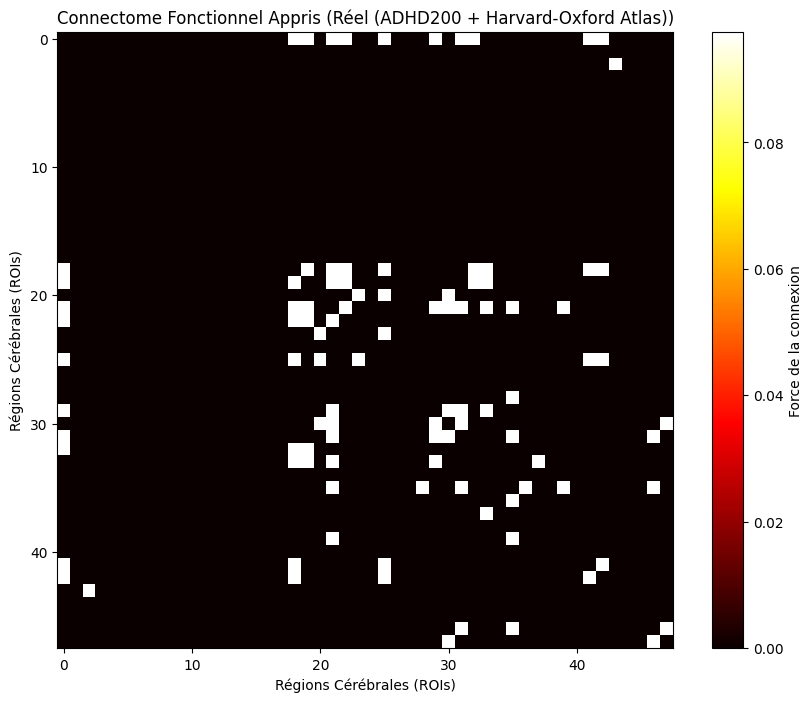


Réseaux Fonctionnels identifiés (26) :
 - Réseau 1 (22 régions) : Frontal Pole, Supramarginal Gyrus, anterior division, Supramarginal Gyrus, posterior division, Angular Gyrus, Lateral Occipital Cortex, superior division...
 - Réseau 2 (1 régions) : Insular Cortex...
 - Réseau 3 (2 régions) : Superior Frontal Gyrus, Planum Polare...
 - Réseau 4 (1 régions) : Middle Frontal Gyrus...
 - Réseau 5 (1 régions) : Inferior Frontal Gyrus, pars triangularis...
 - Réseau 6 (1 régions) : Inferior Frontal Gyrus, pars opercularis...
 - Réseau 7 (1 régions) : Precentral Gyrus...
 - Réseau 8 (1 régions) : Temporal Pole...
 - Réseau 9 (1 régions) : Superior Temporal Gyrus, anterior division...
 - Réseau 10 (1 régions) : Superior Temporal Gyrus, posterior division...
 - Réseau 11 (1 régions) : Middle Temporal Gyrus, anterior division...
 - Réseau 12 (1 régions) : Middle Temporal Gyrus, posterior division...
 - Réseau 13 (1 régions) : Middle Temporal Gyrus, temporooccipital part...
 - Réseau 14 (1 régio

In [201]:
# 3. Application de SGL pour nettoyer le graphe
print("Analyse du Connectome en cours...")
# On force k=4 réseaux majeurs
Theta_brain, w_brain, _, _ = sgl(
    S=S_brain, 
    k=4,            
    alpha=0.5,     
    beta=500,
    tol=1e-4
)

W_brain_hat = adjacency_from_theta(Theta_brain)

# 4. Visualisation (Matrice d'Adjacence / Connectome)
plt.figure(figsize=(10, 8))
plt.imshow(W_brain_hat, cmap='hot', interpolation='nearest')
plt.title(f"Connectome Fonctionnel Appris ({source_type})")
plt.colorbar(label="Force de la connexion")
plt.xlabel("Régions Cérébrales (ROIs)")
plt.ylabel("Régions Cérébrales (ROIs)")
plt.show()

# 5. Affichage des Réseaux Trouvés
G_brain_hat = nx.from_numpy_array(W_brain_hat)
components = list(nx.connected_components(G_brain_hat))
print(f"\nRéseaux Fonctionnels identifiés ({len(components)}) :")
for i, nodes in enumerate(components):
    # On affiche juste les 3 premières régions de chaque réseau
    sample_rois = [roi_labels[n] for n in list(nodes)[:5]] 
    print(f" - Réseau {i+1} ({len(nodes)} régions) : {', '.join(sample_rois)}...")

In [202]:
# --- PARAMÈTRES AGRESSIFS ---
Theta_brain, w_brain, _, _ = sgl(
    S=S_brain, 
    k=4,            # On veut absolument 4 groupes
    alpha=0.55,     # On coupe encore plus de liens faibles
    beta=800.0,     # Force de séparation maximale
    tol=1e-4
)

the best relative error is: 0.11539573991423803
the relative error is: 0.11539573991423803
the best relative error is: 0.06903553951674858
the best relative error is: 0.03561662827140388
the best relative error is: 0.019459592867411845
the best relative error is: 0.011287387556642065
the best relative error is: 0.007189146996007671
the best relative error is: 0.0036930210127675746
the best relative error is: 0.0026944325805603455
the best relative error is: 0.0022094016169419053
the relative error is: 0.002271653462517534
the best relative error is: 0.0020444957553382432
the best relative error is: 0.0014185775960164802
the best relative error is: 0.0011290649051519928
the best relative error is: 0.0010291313080607668
the best relative error is: 0.000982705147641289
the relative error is: 0.0011023829620826144
the best relative error is: 0.0009095477515185748
The best final relative error is: 0.0009095477515185748


In [203]:
!pip install nilearn

Defaulting to user installation because normal site-packages is not writeable


In [204]:
from nilearn import plotting, datasets

# 1. On récupère à nouveau l'objet atlas pour avoir accès aux cartes (maps)
# C'est rapide, nilearn utilise son cache local
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps



[fetch_atlas_harvard_oxford] Dataset found in /home/iliass/nilearn_data/fsl

Lancement de SGL (k=4, alpha=0.0, beta=0.1)...
the best relative error is: 0.037214719114662106
the relative error is: 0.037214719114662106
the relative error is: 0.0427252087771889
the best relative error is: 0.03574976168736168
the best relative error is: 0.03407031356009569
the best relative error is: 0.033511796324657186
the best relative error is: 0.033250634235255185
the best relative error is: 0.03300125608557872
the best relative error is: 0.03286638511180208
the best relative error is: 0.032515246491649365
the relative error is: 0.03265746913751753
the best relative error is: 0.032470693559639295
the best relative error is: 0.03218954247812066
the best relative error is: 0.031682267961910766
the best relative error is: 0.03125867840903227
the best relative error is: 0.031151884401687938
the best relative error is: 0.030749744480657006
the best relative error is: 0.03022469775974921
the best relative error is: 0.029778420565682705
the relative error is: 0.029778420565682705
the

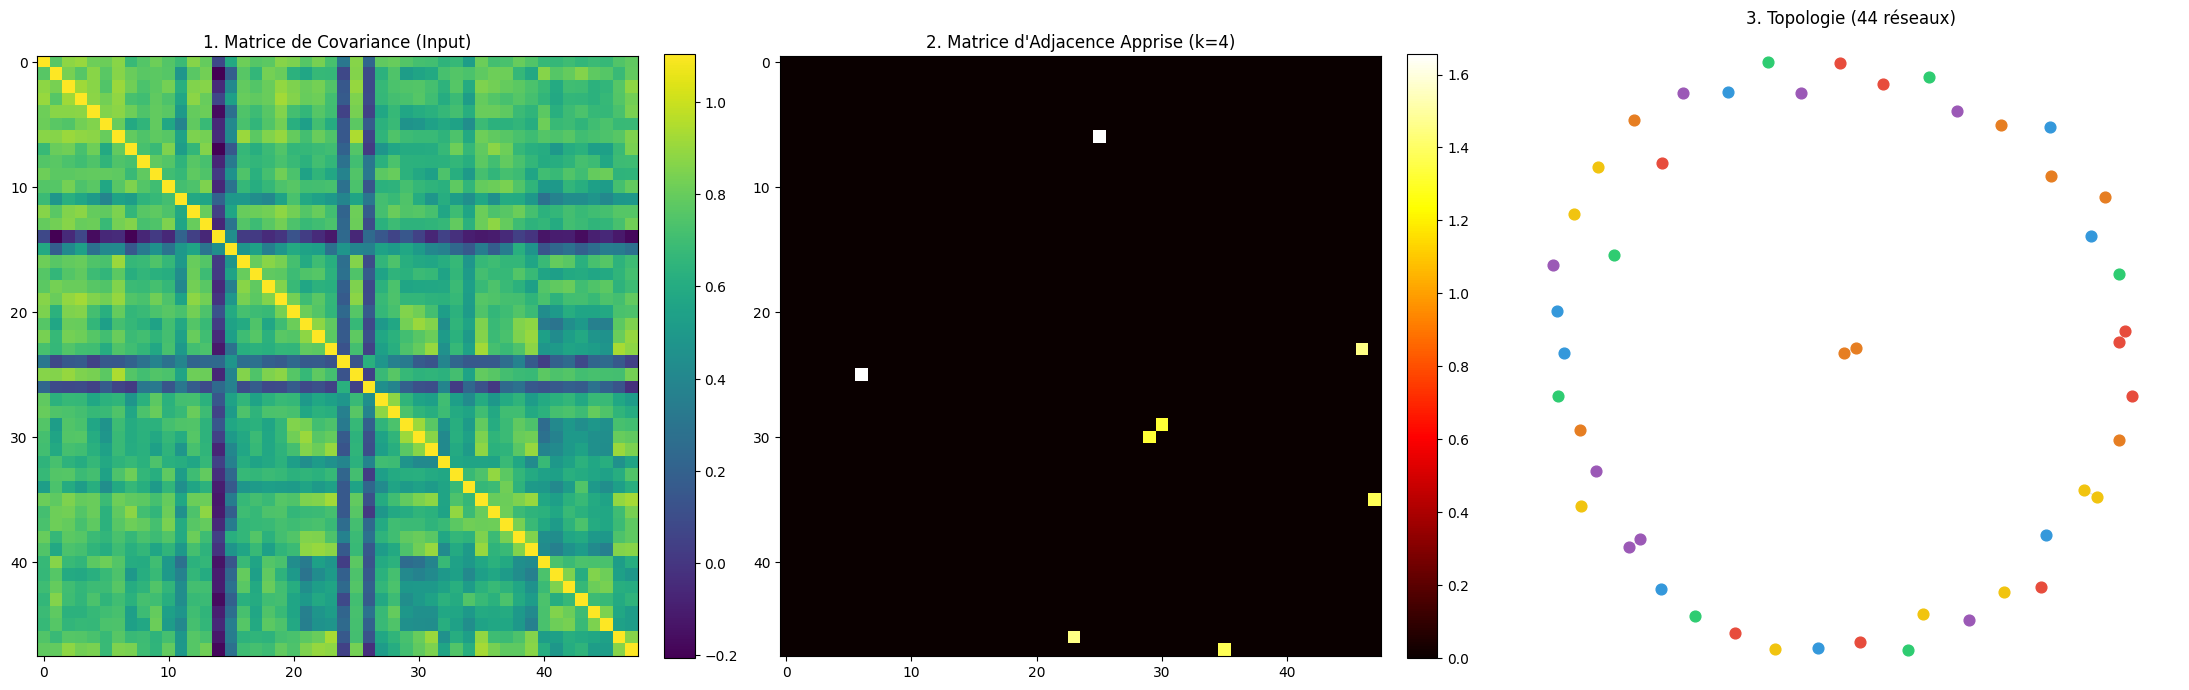


Synthèse : 44 réseaux identifiés.
 - Réseau 1 : 1 régions
 - Réseau 2 : 1 régions
 - Réseau 3 : 1 régions
 - Réseau 4 : 1 régions
 - Réseau 5 : 1 régions
 - Réseau 6 : 1 régions
 - Réseau 7 : 2 régions
 - Réseau 8 : 1 régions
 - Réseau 9 : 1 régions
 - Réseau 10 : 1 régions
 - Réseau 11 : 1 régions
 - Réseau 12 : 1 régions
 - Réseau 13 : 1 régions
 - Réseau 14 : 1 régions
 - Réseau 15 : 1 régions
 - Réseau 16 : 1 régions
 - Réseau 17 : 1 régions
 - Réseau 18 : 1 régions
 - Réseau 19 : 1 régions
 - Réseau 20 : 1 régions
 - Réseau 21 : 1 régions
 - Réseau 22 : 1 régions
 - Réseau 23 : 1 régions
 - Réseau 24 : 2 régions
 - Réseau 25 : 1 régions
 - Réseau 26 : 1 régions
 - Réseau 27 : 1 régions
 - Réseau 28 : 1 régions
 - Réseau 29 : 2 régions
 - Réseau 30 : 1 régions
 - Réseau 31 : 1 régions
 - Réseau 32 : 1 régions
 - Réseau 33 : 1 régions
 - Réseau 34 : 2 régions
 - Réseau 35 : 1 régions
 - Réseau 36 : 1 régions
 - Réseau 37 : 1 régions
 - Réseau 38 : 1 régions
 - Réseau 39 : 1 régions

In [217]:
# --- CELLULE DE VISUALISATION : Covariance -> Adjacence ---
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_sgl_results(S, labels, k=4, alpha=0.5, beta=50):
    """
    Exécute SGL et affiche la comparaison entre l'input (Cov) et l'output (Adj).
    """
    # 1. Calcul de l'apprentissage du graphe (SGL)
    print(f"Lancement de SGL (k={k}, alpha={alpha}, beta={beta})...")
    Theta, _, _, _ = sgl(S=S, k=k, alpha=alpha, beta=beta, tol=1e-5, patience=50, l1 = 50.0)
    W = adjacency_from_theta(Theta)
    
    # 2. Création de la figure
    fig = plt.figure(figsize=(22, 7))
    
    # --- Sous-graphe 1 : Matrice de Covariance (L'entrée) ---
    ax1 = fig.add_subplot(131)
    im1 = ax1.imshow(S, cmap='viridis', interpolation='nearest')
    ax1.set_title("1. Matrice de Covariance (Input)")
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # --- Sous-graphe 2 : Matrice d'Adjacence (Le résultat SGL) ---
    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(W, cmap='hot', interpolation='nearest')
    ax2.set_title(f"2. Matrice d'Adjacence Apprise (k={k})")
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # --- Sous-graphe 3 : Structure du Graphe (Réseaux identifiés) ---
    ax3 = fig.add_subplot(133)
    G = nx.from_numpy_array(W)
    pos = nx.spring_layout(G, seed=42) # Organisation spatiale des points
    
    # Coloration par composante connexe
    components = list(nx.connected_components(G))
    palette = ['#e74c3c', '#3498db', '#2ecc71', '#f1c40f', '#9b59b6', '#e67e22']
    
    for i, nodes in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=list(nodes), 
                               node_color=palette[i % len(palette)], 
                               node_size=60, ax=ax3, label=f"Réseau {i+1}")
    
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', ax=ax3)
    ax3.set_title(f"3. Topologie ({len(components)} réseaux)")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage textuel pour vérification
    print(f"\nSynthèse : {len(components)} réseaux identifiés.")
    for i, nodes in enumerate(components):
        print(f" - Réseau {i+1} : {len(nodes)} régions")

# --- EXECUTION ---
# S_brain doit être ta matrice de corrélation/covariance (shape 2D)
# roi_labels contient les noms des régions
visualize_sgl_results(S_brain, roi_labels, k=4, alpha=0.0, beta=0.1)